In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [48]:
import numpy as np
import pandas as pd
import xarray as xr

import fields
import model
import prediction
import plot

%matplotlib inline

In [3]:
ds = xr.open_dataset("../data/exp_pro/OCO2_MODIS_4x5deg_monthly_conus_augmented.nc")
ds = ds.where(ds.time.dt.year > 2014, drop=True)

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var", "evi"]]

datasets = [ds_xco2, ds_sif]
covariates = [["lon", "lat"], ["evi"]]
timedeltas = [0, -1]
vario_config = fields.VarioConfig(1500, 30)

In [4]:
mf = fields.MultiField(
        datasets, covariates, np.datetime64("2016-08-01"), timedeltas
    )
gamma = mf.empirical_variograms(vario_config)

## Fitting
---

In [5]:
mod = model.FullBivariateMatern()
mod.fit(gamma)
mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.022804,"(0.4, 3.5)"
1,sigma_22,1.111082,"(0.4, 3.5)"
2,nu_11,0.761062,"(0.2, 3.5)"
3,nu_12,3.500000,"(0.2, 3.5)"
4,nu_22,0.865863,"(0.2, 3.5)"
5,len_scale_11,366.394072,"(100.0, 2000.0)"
6,len_scale_12,2000.000000,"(100.0, 2000.0)"
7,len_scale_22,665.881210,"(100.0, 2000.0)"
8,nugget_11,0.057784,"(0.0, 0.2)"
9,nugget_22,0.025702,"(0.0, 0.2)"


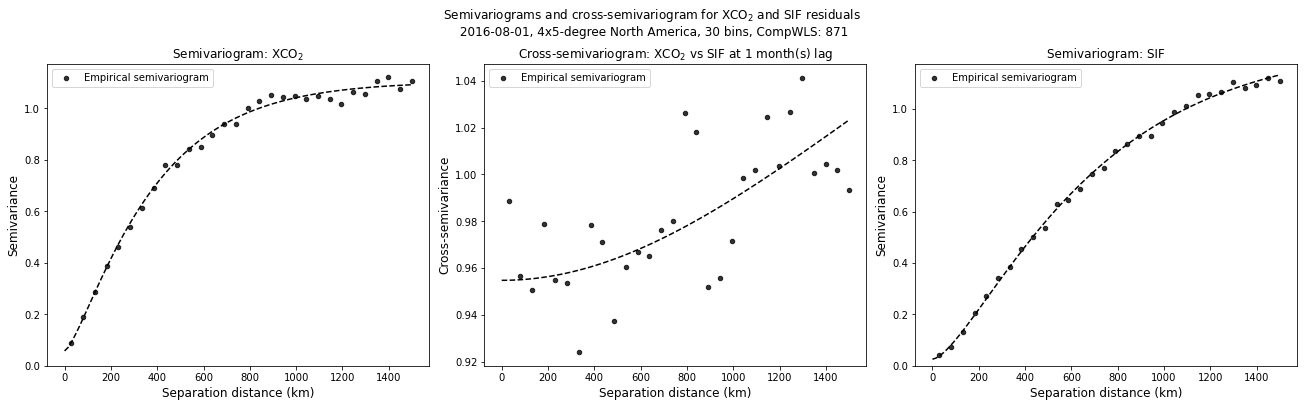

In [6]:
plot.plot_variograms(mod.fit_result, ["XCO$_2$", "SIF"])

## Prediction
---

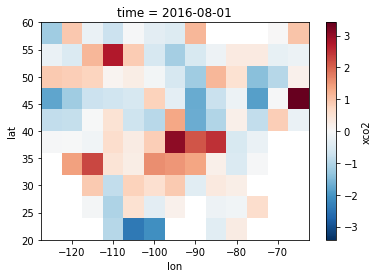

In [8]:
mf.fields[0].ds_main[mf.fields[0].data_name].T.plot()

In [79]:
pcoords = prediction.prediction_coords()
P = prediction.Predictor(mod, mf)
df_pred = P(pcoords, max_dist=1e3)
df_pred

,Latitude,Longitude,pred,pred_err
0,48.5,-125.0,-0.076820,0.798848
1,49.0,-125.0,0.260527,0.724060
2,49.5,-125.0,0.570914,0.590808
3,50.0,-125.0,0.800577,0.430341
4,50.5,-125.0,0.745614,0.592327
...,...,...,...,...
6380,56.0,-65.0,0.274932,0.834794
6381,56.5,-65.0,0.429018,0.813828
6382,57.0,-65.0,0.591344,0.741247
6383,57.5,-65.0,0.760158,0.606456


In [73]:
ds_pred = df_pred.set_index(["Longitude", "Latitude"]).to_xarray()
ds_pred

<xarray.Dataset>
Dimensions:    (Longitude: 121, Latitude: 73)
Coordinates:
  * Longitude  (Longitude) float64 -125.0 -124.5 -124.0 ... -66.0 -65.5 -65.0
  * Latitude   (Latitude) float64 22.0 22.5 23.0 23.5 ... 56.5 57.0 57.5 58.0
Data variables:
    pred       (Longitude, Latitude) float64 nan nan nan ... 0.7602 0.8874
    pred_err   (Longitude, Latitude) float64 nan nan nan ... 0.6065 0.4316

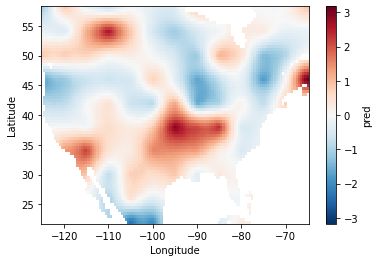

In [74]:
ds_pred["pred"].T.plot()

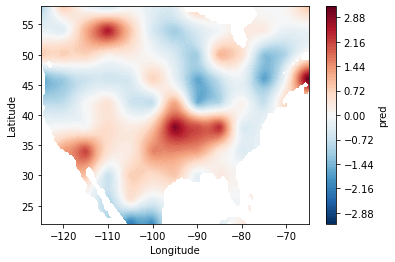

In [75]:
xr.plot.contourf(ds_pred["pred"].T, levels=100)

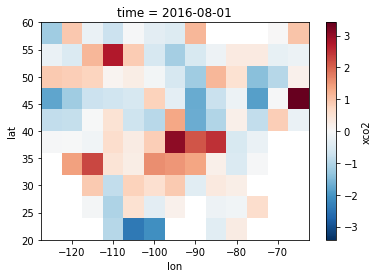

In [41]:
mf.fields[0].ds_main[mf.fields[0].data_name].T.plot()